In [271]:
import pandas as pd
import matplotlib.pyplot as plt

In [272]:
path='../../../data/MDataFiles_Stage1/'

In [273]:
teams = pd.read_csv(path+'MTeams.csv')
seasons = pd.read_csv(path+'MSeasons.csv')
seeds = pd.read_csv(path+'MNCAATourneySeeds.csv')
coaches=pd.read_csv(path+'MTeamCoaches.csv')


In [274]:
regular_results = pd.read_csv(path+'MRegularSeasonCompactResults.csv')
bracket_res = pd.read_csv(path+'MNCAATourneyCompactResults.csv')

In [275]:
regular_detail = pd.read_csv(path+'MRegularSeasonDetailedResults.csv')
bracket_detail = pd.read_csv(path+'MNCAATourneyDetailedResults.csv')

In [276]:
cities=pd.read_csv(path+'Cities.csv')
cities_games = pd.read_csv(path+'MGameCities.csv')

In [277]:
ranks=pd.read_csv(path+'MMasseyOrdinals.csv')


### On regarde si les équipes en D1 ont beaucoup changé au cours du temps.

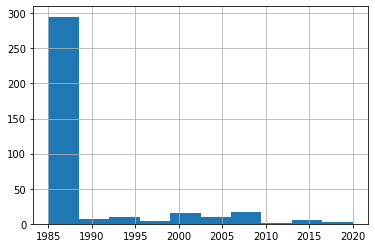

In [278]:
teams['FirstD1Season'].hist()

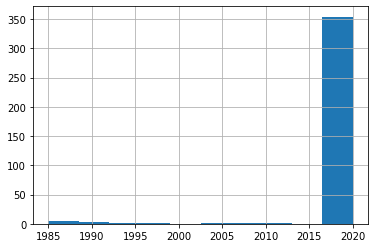

In [279]:
teams['LastD1Season'].hist()

### Quelques résultats sur la saison régulière.

In [280]:
regular_results.sample(4)

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
153110,2018,68,1186,82,1170,67,H,0
11186,1987,124,1299,91,1354,75,H,0
11428,1987,132,1207,69,1393,59,N,0
89481,2006,59,1365,77,1137,68,H,0


In [281]:
nb_Adverse=regular_detail[regular_detail['WLoc']=='A'].shape[0]
nb_Home=regular_detail[regular_detail['WLoc']=='H'].shape[0]
nb_Neutral=regular_detail[regular_detail['WLoc']=='N'].shape[0]
nb_Total=nb_Adverse+nb_Home+ nb_Neutral
print("Pourcentage de matchs gagnés à la maison")
print(nb_Home/(nb_Total))

print("Pourcentage de matchs gagnés en terrain neutre")
print(nb_Neutral/nb_Total)

print("Pourcentage de matchs perdus à la maison")
print(nb_Adverse/(nb_Total))

# On observe les matchs "gagnés", on remarque que 90 % en saison régulière sont joués en terrain adverse ou à la maison
# beaucoup plus sont gagnés lorsque le match se fait à la maison

Pourcentage de matchs gagnés à la maison
0.5922586396050467
Pourcentage de matchs gagnés en terrain neutre
0.10193819711098921
Pourcentage de matchs perdus à la maison
0.3058031632839642


### On veut récupérer des features par équipe et par saison, pour pouvoir les ajouter à notre modèle qui va prendre en compte avec chaque match les features des deux équipes qui s'affrontent, à la saison regardée.

In [315]:
bracket_res=bracket_res[bracket_res['Season']<2015]
bracket_res["Type_tournoi"]='MM'
regular_results["Type_tournoi"]='Reg'

bracket_detail = bracket_detail[bracket_detail['Season']<2015]
bracket_detail["Type_tournoi"]='MM'
regular_detail["Type_tournoi"]='Reg'


In [316]:
regular_results=pd.concat([regular_results, bracket_res])
regular_detail=pd.concat([regular_detail, bracket_detail])

In [317]:
regular_results.head(2)

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,Type_tournoi
0,1985,20,1228,81,1328,64,N,0,Reg
1,1985,25,1106,77,1354,70,H,0,Reg


Nos premières pistes d’exploration pour les features: 

- Taux de victoire en saison régulière
- Confiance de l’équipe : Différence de buts moyenne lors la saison régulière ? Nombre de victoires en terrain adverse ?
- Ancienneté en D1
- Evolution sur les deux/trois dernières années (résultat au March Madness ? Evolution du taux de victoire?)
- Qualité de la défense: nombre de buts encaissés, nombre de “Steals” réalisés ?
- Qualité de l’attaque: nombre de buts mis, nombres de buts tentés, pourcentage de précision ?
- Volonté : nombre de victoires au March Madness précédents ? 


In [318]:
# On crée notre fichier, qui va contenir des stats en fonction de l'équipe, la saison
# si l'on est en March Madness ou en saison régulière
victories_per_season=regular_results.groupby(['WTeamID', 'Season', 'Type_tournoi'], as_index=False).agg('count')


In [319]:
# On commence par simplement compter le nombre de victoires
victories_per_season['Nombre_victoires']=victories_per_season['DayNum']
victories_per_season=victories_per_season[['WTeamID', 'Season', 'Type_tournoi', 'Nombre_victoires']]
victories_per_season.head(3)

,WTeamID,Season,Type_tournoi,Nombre_victoires
0,1101,2014,Reg,2
1,1101,2015,Reg,7
2,1101,2016,Reg,9


In [320]:
# et de défaites
victories_per_season['Nombre_défaites']=regular_results.groupby(['LTeamID', 'Season', 'Type_tournoi'], as_index=False).agg('count')['DayNum']
victories_per_season.sample(3)

,WTeamID,Season,Type_tournoi,Nombre_victoires,Nombre_défaites
1368,1145,2012,Reg,5,9
9486,1387,2008,Reg,16,26
8529,1358,1998,Reg,9,8


In [321]:
victories_per_season['Nombre_matchs']=victories_per_season['Nombre_défaites']+victories_per_season['Nombre_victoires']
# cela nous donne un pourcentage
victories_per_season['Pourcentage_Victoire']=victories_per_season['Nombre_victoires']/victories_per_season['Nombre_matchs']

In [322]:
# En vu d'une feature qualité de la défense (buts encaissés, ?)
victories_per_season['Buts_moyens_encaissés_V']=regular_results.groupby(['WTeamID', 'Season', 'Type_tournoi'], as_index=False).sum()['LScore']
victories_per_season['Buts_moyens_encaissés_D']=regular_results.groupby(['LTeamID', 'Season', 'Type_tournoi'], as_index=False).sum()['WScore']
victories_per_season['Buts_moyens_encaissés']=(victories_per_season['Buts_moyens_encaissés_V']+victories_per_season['Buts_moyens_encaissés_D'])/victories_per_season['Nombre_matchs']

victories_per_season.sample(3)

,WTeamID,Season,Type_tournoi,Nombre_victoires,Nombre_défaites,Nombre_matchs,Pourcentage_Victoire,Buts_moyens_encaissés_V,Buts_moyens_encaissés_D,Buts_moyens_encaissés
3605,1210,2006,Reg,11,12,23,0.478261,683,1000,73.173913
7664,1332,2004,Reg,15,11,26,0.576923,996,895,72.730769
3011,1193,2011,Reg,24,17,41,0.585366,1302,1321,63.975610


In [323]:
# En vu d'une feature qualité de l'attaque
victories_per_season['Buts_moyens_marqués_V']=regular_results.groupby(['WTeamID', 'Season', 'Type_tournoi'], as_index=False).sum()['WScore']

victories_per_season['Buts_moyens_marqués_D']=regular_results.groupby(['LTeamID', 'Season', 'Type_tournoi'], as_index=False).sum()['LScore']

victories_per_season['Buts_moyens_marqués']=(victories_per_season['Buts_moyens_marqués_V']+victories_per_season['Buts_moyens_marqués_D'])/victories_per_season['Nombre_matchs']

victories_per_season['Moyenne_diff_score']=victories_per_season['Buts_moyens_marqués']-victories_per_season['Buts_moyens_encaissés']

In [324]:
victories_per_season.sample(2)

,WTeamID,Season,Type_tournoi,Nombre_victoires,Nombre_défaites,Nombre_matchs,Pourcentage_Victoire,Buts_moyens_encaissés_V,Buts_moyens_encaissés_D,Buts_moyens_encaissés,Buts_moyens_marqués_V,Buts_moyens_marqués_D,Buts_moyens_marqués,Moyenne_diff_score
7968,1341,1985,Reg,5,8,13,0.384615,369,550,70.692308,404,495,69.153846,-1.538462
372,1113,1993,Reg,17,10,27,0.629630,1306,871,80.629630,1522,811,86.407407,5.777778


### Mental

In [325]:
# Feature mental (% de matchs gagnés sur terrain adverse)
victories_per_season['Victoires_sur_terrain_adverse']=(regular_results[regular_results['WLoc']=='A']).groupby(['WTeamID', 'Season', 'Type_tournoi'], as_index=False).count()['NumOT']
victories_per_season['Victoires_sur_terrain_adverse'].fillna(0, inplace=True)
victories_per_season['Défaites_sur_terrain_adverse']=(regular_results[regular_results['WLoc']=='H']).groupby(['LTeamID', 'Season', 'Type_tournoi'], as_index=False).count()['NumOT']
victories_per_season['Défaites_sur_terrain_adverse'].fillna(0, inplace=True)
victories_per_season['Pourcentage_V_terrain_adverse']=victories_per_season['Victoires_sur_terrain_adverse']/(victories_per_season['Victoires_sur_terrain_adverse']+victories_per_season['Défaites_sur_terrain_adverse'])
victories_per_season['Pourcentage_V_terrain_adverse'].fillna(0.1, inplace=True)

In [326]:
# victories_per_season.isna().sum()

In [327]:
# On regarde si leurs taux de victoire augmente lors d'un enjeu (match en terrain adverse), cela nous donne leur mental

victories_per_season['Mental']=100*(victories_per_season['Pourcentage_V_terrain_adverse']-victories_per_season['Pourcentage_Victoire'])

### Evolution récente de l'équipe

In [328]:
# Evolution par rapport à l'année dernière
victories_per_season['Evolution_1_year']=victories_per_season['Pourcentage_Victoire'].diff(periods=1)
victories_per_season['Evolution_1_year'].fillna(0.05, inplace=True)

In [329]:
# Evolution sur ces deux dernières années
victories_per_season['Evolution_2_Last_years']=victories_per_season['Pourcentage_Victoire'].diff(periods=2)
victories_per_season['Evolution_2_Last_years'].fillna(0.05, inplace=True)

### Etude des Fools, Steals et Blocks

In [330]:
# Est-ce que leurs erreurs sont récurrentes et ont une influence ?
victories_per_season['Fools_W']=regular_detail.groupby(['WTeamID', 'Season', 'Type_tournoi'], as_index=False).sum()['WPF']
victories_per_season['Fools_D']=regular_detail.groupby(['WTeamID', 'Season', 'Type_tournoi'], as_index=False).sum()['LPF']
victories_per_season['Fools']=victories_per_season['Fools_W']+victories_per_season['Fools_D']
victories_per_season.fillna(0, inplace=True)
victories_per_season['Fools']=victories_per_season['Fools']/victories_per_season['Nombre_matchs']

In [331]:
# Est-ce que leurs blocks sont récurrentes et ont une influence ?
victories_per_season['Blocks_W']=regular_detail.groupby(['WTeamID', 'Season', 'Type_tournoi'], as_index=False).sum()['WBlk']
victories_per_season['Blocks_D']=regular_detail.groupby(['WTeamID', 'Season', 'Type_tournoi'], as_index=False).sum()['LBlk']
victories_per_season['Blocks']=victories_per_season['Blocks_W']+victories_per_season['Blocks_D']
victories_per_season.fillna(0, inplace=True)
victories_per_season['Blocks']=victories_per_season['Blocks']/victories_per_season['Nombre_matchs']

In [332]:
# Est-ce que leurs blocks sont récurrentes et ont une influence ?
victories_per_season['Steals_W']=regular_detail.groupby(['WTeamID', 'Season', 'Type_tournoi'], as_index=False).sum()['WStl']
victories_per_season['Steals_D']=regular_detail.groupby(['WTeamID', 'Season', 'Type_tournoi'], as_index=False).sum()['LStl']
victories_per_season['Steals']=victories_per_season['Steals_W']+victories_per_season['Steals_D']
victories_per_season.fillna(0, inplace=True)
victories_per_season['Steals']=victories_per_season['Steals']/victories_per_season['Nombre_matchs']

### Défense

In [333]:
buts_e_max=victories_per_season['Buts_moyens_encaissés'].max()
steals_max=victories_per_season['Steals'].max()
blocks_max=victories_per_season['Blocks'].max()
victories_per_season["Qualité_Défense"]=buts_e_max-victories_per_season['Buts_moyens_encaissés']+victories_per_season['Steals'] + victories_per_season['Blocks']

### Attaque

In [334]:
buts_m_max=victories_per_season['Buts_moyens_marqués'].max()
victories_per_season["Qualité_Attaque"]=victories_per_season['Buts_moyens_marqués']

### Confiance

In [335]:
victories_per_season['Confiance']=victories_per_season['Moyenne_diff_score']+victories_per_season['Victoires_sur_terrain_adverse']-10*victories_per_season['Fools']

In [336]:
victories_per_season.columns

Index(['WTeamID', 'Season', 'Type_tournoi', 'Nombre_victoires',
       'Nombre_défaites', 'Nombre_matchs', 'Pourcentage_Victoire',
       'Buts_moyens_encaissés_V', 'Buts_moyens_encaissés_D',
       'Buts_moyens_encaissés', 'Buts_moyens_marqués_V',
       'Buts_moyens_marqués_D', 'Buts_moyens_marqués', 'Moyenne_diff_score',
       'Victoires_sur_terrain_adverse', 'Défaites_sur_terrain_adverse',
       'Pourcentage_V_terrain_adverse', 'Mental', 'Evolution_1_year',
       'Evolution_2_Last_years', 'Fools_W', 'Fools_D', 'Fools', 'Blocks_W',
       'Blocks_D', 'Blocks', 'Steals_W', 'Steals_D', 'Steals',
       'Qualité_Défense', 'Qualité_Attaque', 'Confiance'],
      dtype='object')

In [337]:
victories_per_season.drop(['Buts_moyens_encaissés_V', 'Buts_moyens_encaissés_D', 'Buts_moyens_marqués_V', 'Buts_moyens_marqués_D','Victoires_sur_terrain_adverse',
       'Défaites_sur_terrain_adverse', 'Fools_W', 'Fools_D', 'Blocks_W','Blocks_D', 'Steals_W', 'Steals_D' ], axis=1, inplace=True)

### Ancienneté en D1

In [338]:
victories_per_season=victories_per_season.merge(teams, how='left', left_on='WTeamID', right_on='TeamID')
victories_per_season['Ancienneté']=victories_per_season['Season']-victories_per_season['FirstD1Season']
victories_per_season.drop(['TeamID', 'TeamName', 'FirstD1Season', 'LastD1Season' ], axis=1, inplace=True)

In [339]:
reg_season=victories_per_season[victories_per_season['Type_tournoi']=='Reg']

### Nombre de participations à des March Madness

In [340]:
df=bracket_res.groupby(['Season', 'WTeamID'], as_index=False).count()
nb_participation=df[df['Season']<2015].groupby('WTeamID', as_index=False).count()

In [341]:
teams2=teams.merge(nb_participation, how='left',  left_on='TeamID', right_on='WTeamID')

In [342]:
teams2['Nombre_participations_MM']=teams2['Season']
teams2.fillna(0,inplace=True)
teams2=teams2[['TeamID', 'Nombre_participations_MM']]

In [343]:
victories_per_season=victories_per_season.merge(teams2, how='left', left_on='WTeamID', right_on='TeamID')
victories_per_season.drop(['TeamID'], axis=1, inplace=True)
victories_per_season.head()

,WTeamID,Season,Type_tournoi,Nombre_victoires,Nombre_défaites,Nombre_matchs,Pourcentage_Victoire,Buts_moyens_encaissés,Buts_moyens_marqués,Moyenne_diff_score,...,Evolution_1_year,Evolution_2_Last_years,Fools,Blocks,Steals,Qualité_Défense,Qualité_Attaque,Confiance,Ancienneté,Nombre_participations_MM
0,1101,2014,Reg,2,19,21,0.095238,78.619048,63.142857,-15.476190,...,0.050000,0.050000,4.190476,0.333333,1.761905,33.240896,63.142857,-56.380952,0,0.0
1,1101,2015,Reg,7,21,28,0.250000,71.857143,61.000000,-10.857143,...,0.154762,0.050000,9.607143,1.107143,3.000000,42.014706,61.000000,-104.928571,1,0.0
2,1101,2016,Reg,9,18,27,0.333333,76.259259,69.851852,-6.407407,...,0.083333,0.238095,15.370370,1.962963,4.444444,39.912854,69.851852,-156.111111,2,0.0
3,1101,2017,Reg,9,16,25,0.360000,72.640000,67.880000,-4.760000,...,0.026667,0.110000,15.360000,1.880000,4.720000,43.724706,67.880000,-152.360000,3,0.0
4,1101,2018,Reg,12,15,27,0.444444,72.814815,70.666667,-2.148148,...,0.084444,0.111111,16.666667,3.703704,5.074074,45.727669,70.666667,-158.814815,4,0.0


In [349]:
# Pour étudier la corrélation :
reg_season=victories_per_season.copy()
reg_season['Victoires_MM']=bracket_res.groupby(['WTeamID', 'Season'], as_index=False).agg('count')['DayNum']


In [350]:
cols = reg_season.columns.tolist() 
cols = cols[-1:] + cols[:-1]
reg_season = reg_season[cols]

## Corrélation entre les résultats en saison régulière et le nombre de victoires au March Madness

Finalement, on constate très peu de corrélations entre les stats sur la saison régulière et les résultats au March Madness, ce qui nous fait dire que c'est un contexte très particulier.

In [351]:
reg_season.corr(method='pearson')

,Victoires_MM,WTeamID,Season,Nombre_victoires,Nombre_défaites,Nombre_matchs,Pourcentage_Victoire,Buts_moyens_encaissés,Buts_moyens_marqués,Moyenne_diff_score,...,Evolution_1_year,Evolution_2_Last_years,Fools,Blocks,Steals,Qualité_Défense,Qualité_Attaque,Confiance,Ancienneté,Nombre_participations_MM
Victoires_MM,1.000000,-0.093179,0.003869,-0.072369,0.030661,-0.031297,-0.083289,-0.005677,-0.080227,-0.066556,...,-0.036897,-0.056879,0.066964,0.069761,0.075482,0.073085,-0.080227,-0.068211,-0.014230,0.066087
WTeamID,-0.093179,1.000000,0.000673,0.033834,-0.051099,-0.010487,0.053042,-0.039663,0.029642,0.060255,...,-0.000370,-0.000574,-0.422116,-0.401714,-0.409046,-0.370740,0.029642,0.421025,0.014121,0.022900
Season,0.003869,0.000673,1.000000,0.126066,-0.016029,0.080447,0.084693,-0.154620,-0.068477,0.072023,...,0.001307,0.016556,-0.038874,-0.041127,-0.041855,0.016083,-0.068477,0.040673,0.890525,-0.069536
Nombre_victoires,-0.072369,0.033834,0.126066,1.000000,0.004127,0.728119,0.588860,-0.350049,0.361989,0.620627,...,0.505936,0.351573,-0.225281,-0.215558,-0.220769,-0.081762,0.361989,0.240498,0.159991,0.173380
Nombre_défaites,0.030661,-0.051099,-0.016029,0.004127,1.000000,0.688450,-0.723905,0.361545,-0.417536,-0.679649,...,-0.309393,-0.354537,-0.207040,-0.195965,-0.201165,-0.318542,-0.417536,0.190708,-0.002357,-0.013958
Nombre_matchs,-0.031297,-0.010487,0.080447,0.728119,0.688450,1.000000,-0.069111,-0.006064,-0.023656,-0.015735,...,0.154875,0.011973,-0.305311,-0.290668,-0.298011,-0.277648,-0.023656,0.305152,0.114425,0.116183
Pourcentage_Victoire,-0.083289,0.053042,0.084693,0.588860,-0.723905,-0.069111,1.000000,-0.515274,0.527955,0.909235,...,0.662235,0.562856,0.020793,0.017122,0.016977,0.201018,0.527955,0.001257,0.087443,0.015713
Buts_moyens_encaissés,-0.005677,-0.039663,-0.154620,-0.350049,0.361545,-0.006064,-0.515274,1.000000,0.341849,-0.555216,...,-0.316564,-0.265505,0.017734,0.014921,0.018735,-0.342322,0.341849,-0.031175,-0.156654,-0.034344
Buts_moyens_marqués,-0.080227,0.029642,-0.068477,0.361989,-0.417536,-0.023656,0.527955,0.341849,1.000000,0.591799,...,0.330758,0.291901,0.028289,0.024160,0.026891,-0.098085,1.000000,-0.013891,-0.052581,0.130144
Moyenne_diff_score,-0.066556,0.060255,0.072023,0.620627,-0.679649,-0.015735,0.909235,-0.555216,0.591799,1.000000,...,0.564265,0.486079,0.009825,0.008583,0.007729,0.206823,0.591799,0.014447,0.087836,0.144639


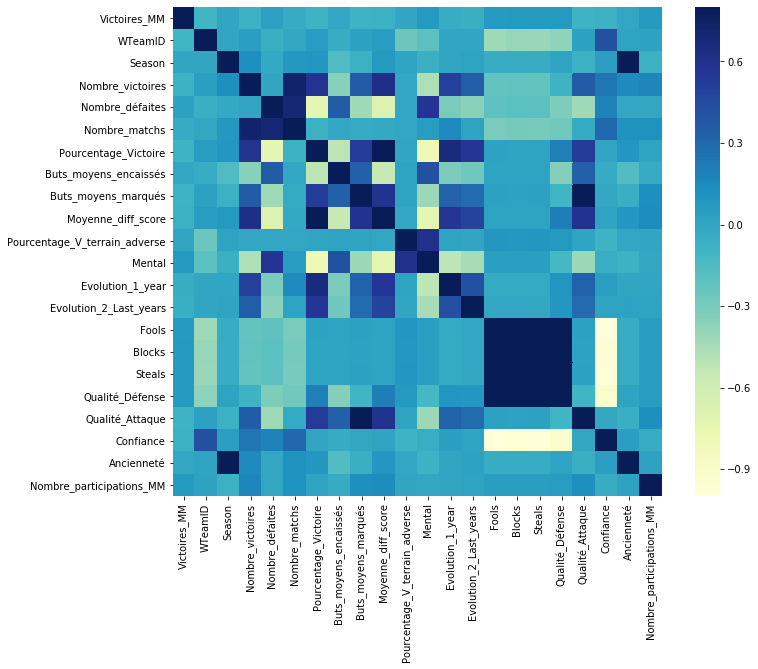

In [352]:
import seaborn as sns
import numpy as np

corrmat = reg_season.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True, cmap="YlGnBu");

In [194]:
# On ne garde pas toutes les features

victories_per_season.drop(['Buts_moyens_encaissés', 'Nombre_victoires', 'Nombre_défaites', 'Type_tournoi', 'Nombre_matchs', 'Buts_moyens_marqués', 'Pourcentage_Victoire', 'Victoires_MM'], axis=1, inplace=True)
victories_per_season.rename(columns={"WTeamID": "TeamID"}, inplace=True)
victories_per_season.head(2)

In [353]:
victories_per_season.to_csv("features_reg_update.csv",index=False)

In [354]:
reg_season.shape

(12209, 23)